In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.layers import variance_scaling_initializer

## load images into batches

In [3]:
## CelebA Dataset - Large-scale CelebFaces Attributes Dataset
## http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

from glob import glob
from os import path

def load_celebrity_batches(image_dir, image_size=(218, 178), batch_size=64):
    files = tf.train.string_input_producer(glob(path.join(image_dir, "*.jpg")))
    reader = tf.WholeFileReader()
    _, raw_img = reader.read(files)
    img = tf.image.decode_jpeg(raw_img)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # explicitly set the shape
    h, w = image_size
    img = tf.image.resize_image_with_crop_or_pad(img, h, w)
    img.set_shape([h, w, 1])
    img_batches = tf.train.shuffle_batch([img],
                                         batch_size=batch_size,
                                         capacity=batch_size*100,
                                         min_after_dequeue=10*batch_size,
                                         num_threads=3)
    return img_batches

(64, 100, 100, 1) float32 0.0 1.0


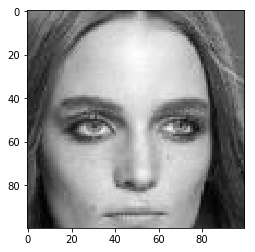

In [4]:
## test image batch
tf.reset_default_graph()
img_batches = load_celebrity_batches("/home/dola/ws/data/celebA/", image_size=(100, 100))

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    sess.run(tf.global_variables_initializer())
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    test_imgs = sess.run(img_batches)
    print(test_imgs.shape, test_imgs.dtype, test_imgs.min(), test_imgs.max())
    plt.imshow(np.squeeze(test_imgs[0]), cmap=plt.cm.gray)
    
    coord.request_stop()
    coord.join(threads)

## build a generative autoencoder - mapping images to a manifold with a Gaussian distribution

The model is probably too simple to capture anything.

In [21]:
h, w = (100, 100)
batch_size = 64

image_dir = "/home/dola/ws/data/celebA/"
n_images = len(glob(path.join(image_dir, "*.jpg")))

n_inputs = h * w * 1
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 100 # coding
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

activation_fn = tf.nn.elu
he_initializer = variance_scaling_initializer()

tf.reset_default_graph()

with tf.name_scope("GAE"):
    with tf.contrib.framework.arg_scope([fully_connected], 
                                       activation_fn=activation_fn,
                                       weights_initializer=he_initializer):
        imgs = load_celebrity_batches(image_dir, image_size=(h,w), batch_size=batch_size)
        X = tf.reshape(imgs, [-1, n_inputs])
        h1 = fully_connected(X, n_hidden1)
        h2 = fully_connected(h1, n_hidden2)
        h3_mean = fully_connected(h2, n_hidden3, activation_fn=None)
        h3_gamma = fully_connected(h2, n_hidden3, activation_fn=None)
        h3_sigma = tf.exp(0.5 * h3_gamma)
        noise = tf.random_normal(tf.shape(h3_gamma), dtype=tf.float32)
        h3 = h3_mean + noise * h3_sigma
        h4 = fully_connected(h3, n_hidden4)
        h5 = fully_connected(h4, n_hidden5)
        logits = fully_connected(h5, n_outputs, activation_fn=None)
        outputs = tf.nn.sigmoid(logits)
        
with tf.name_scope("metrics"):
    xentropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X)
    reconstruction_loss = tf.reduce_mean(xentropy)
    latent_loss = 0.5 * tf.reduce_mean(
        tf.exp(h3_gamma) + tf.square(h3_mean) - 1 - h3_gamma)
    loss = reconstruction_loss + latent_loss
    
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss)
    
saver = tf.train.Saver()

In [7]:
n_images // 64

3165

In [8]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    for epoch in range(5):
        for ibatch in range(n_images // batch_size):
            sess.run(train_op)
            if ibatch % 1000 == 0:
                train_loss, train_rec, train_latent = sess.run([
                    loss, reconstruction_loss, latent_loss
                ])
                print(epoch, ibatch, train_loss, train_rec, train_latent)
        saver.save(sess, "./celebA-gae.chkpt", global_step=epoch)
    coord.request_stop()
    coord.join(threads)

0 0 1.2706e+09 5925.97 1.27059e+09
0 1000 16.8786 0.662651 16.216
0 2000 9.93378 0.649108 9.28468
0 3000 8.76702 0.639802 8.12722
1 0 8.8322 0.642195 8.19
1 1000 9.13872 0.651008 8.48771
1 2000 12.3683 0.638253 11.73
1 3000 8.8576 0.647112 8.21049
2 0 10.146 0.652811 9.49319


KeyboardInterrupt: 

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: GAE/input_producer/input_producer_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](GAE/input_producer, GAE/input_producer/RandomShuffle)]]

Caused by op 'GAE/input_producer/input_producer_EnqueueMany', defined at:
  File "/home/dola/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/dola/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/dola/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/dola/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/dola/anaconda3/lib/python3.6/site-packages/ipykernel/kernela

In [22]:


with tf.Session() as sess:
    saver.restore(sess, "./celebA-gae.chkpt-3")
    recontructed_imgs = sess.run(outputs, feed_dict={imgs: test_imgs})
    generated_imgs = sess.run(outputs, 
                              feed_dict={h3: np.random.normal(size=[64, n_hidden3])})

In [25]:
def show_image_grid(images, nrows, ncols, grid_size=2, gray=True):
    fig, axes = plt.subplots(nrows, ncols, 
                             figsize=(grid_size*ncols, grid_size*nrows))
    fig.subplots_adjust(wspace=0, hspace=0)
    axes = axes.ravel()
    cmap = plt.cm.gray if gray else None
    for img, ax in zip(images, axes):
        ax.imshow(img, cmap=cmap)
        ax.set_axis_off()

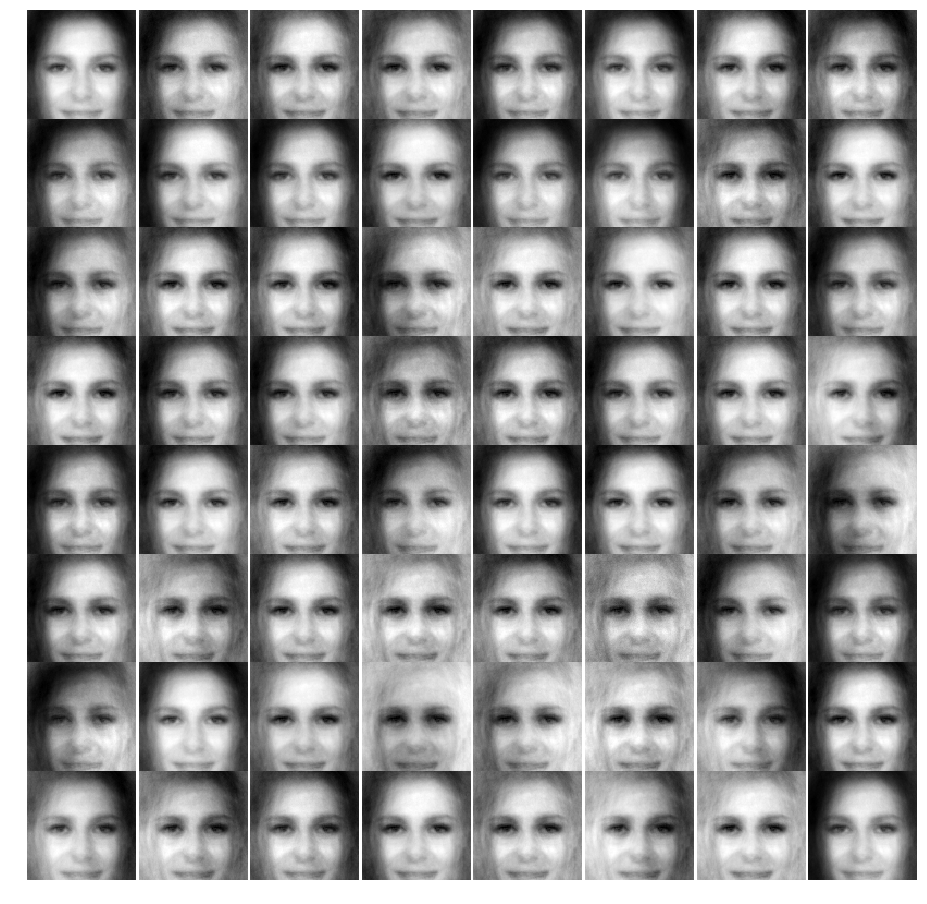

In [26]:
show_image_grid(generated_imgs.reshape([-1, h, w]), 8, 8)